# MODELO FINAL

El modelo escogido para clasificar si el precio del mercado intradiario 1 será inferior (RESERVA = 1) o superior (RESERVA = 0) al precio del mercado diario, tras estudiar varias opciones (*Modelo_Clasificador_1.ipynb, Modelo_Clasificador_2.ipynb, Modelo_Clasificador_3.ipynb, Modelo_XGBoos_FSelect.ipynb* dentro de la carpeta *Modelo*), es:

* Modelo XGBoost, n_estimators=500.
* Features:

    * **PERIODO**: variable categórica que representa la hora del día expresado como la finalización de la hora de estudio. 

    * **WD**: variable categórica que toma valores del 1 al 7 para describir el día de la semana. Los festivos nacionales se han considerado tipo 7 (domingo).

    * **PRECIO_MD_ESP**: variable cuantitativa del precio de casación en el mercado diario para un PERIODO, FECHA.

    * **P48_EOLICA**: Variable cuantitativa de la producción eólica horaria. 

    * **P48_DEMANDA**: Variable cuantitativa de la demanda horaria.

    * **POT_DISP_CARBON**: Variable cuantitativa de la potencia de generación disponible de carbón.

    * **CARBON_D-1**: Variable cuantitativa creada en el notebook *Exploracion_datos.ipynb* resultado de dividir la producción de carbón horaria que hubo el día anterior entre el número de centrales de carbón que estaban arrancadas.

    * **EMB_ANUALES y EMB_HIPERANUALES**: Variable cuantitativa del total peninsular de la cantidad de energía eléctrica que se produciría en su propia central y en todas las centrales situadas aguas abajo, con el vaciado completo de su reserva útil de agua en dicho momento, en el supuesto de que este vaciado se realice sin aportaciones naturales. Los primeros son aquellos cuyo ciclo de llenado y vaciado dura un año mientras que los embalses de régimen hiperanual son aquellos que permiten compensar las variaciones de hidraulicidad en ciclos de más de un año de duración.
    
* Tamaño dataset: 2 años hidráulicos - desde 01/10/2016 - 30/09/2018

En este notebook se analiza el resultado obtenido y la salida que ofrece de cara a utilizarlo en producción. 

Importamos librerías necesarias:

In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from sklearn import tree
import graphviz     #conda install python-graphviz

El modelo escogido es el Modelo_4, guardado en la ruta:

In [15]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo4/'

*Nota: El resultado de este modelo y el set de entrenamiento y test se han subido a Github en la carpeta **Resultados/data&model/**. Para utilizar este notebook, descargar estos ficheros en alguna ruta local del ordenador y modificar la variable path*

Extraigo la división utilizada de train-test y nos traemos el dataset completo:

In [16]:
X_train = pickle.load(open(path + "X_train.pkl","rb"))
X_test = pickle.load(open(path + "X_test.pkl","rb"))
y_train = pickle.load(open(path + "y_train.pkl","rb"))
y_test = pickle.load(open(path + "y_test.pkl","rb"))
model=pickle.load(open(path + "clfxb_4.pkl","rb"))

In [21]:
attributes_column=X_train.columns
list(attributes_column)

['PERIODO',
 'WD',
 'PRECIO_MD_ESP',
 'P48_EOLICA',
 'P48_DEMANDA',
 'POT_DISP_CARBON',
 'CARBON_D-1',
 'EMB_ANUALES',
 'EMB_HIPERANUALES']

Extraigo también el dataset completo, con la fecha.

In [22]:
df=pd.read_csv('../data_processed/data_processed_definitive.csv',sep=';',index_col=False,parse_dates=['FECHA'])
df_new=df[df['FECHA']>'2016-09-30'].copy()
df_new=df_new.drop(['ACOPLADO_FR','RESERVA_D-1','MES'],axis=1).copy()

X=df_new[attributes_column]
y=df_new['RESERVA']

## RESULTADO: Feature importances

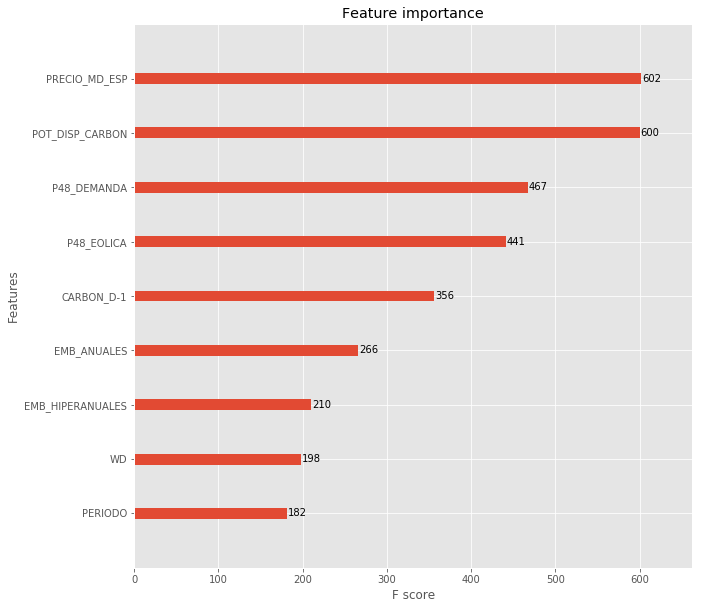

In [77]:
plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

A pesar de que la importancia de las variables disminuye drásticamente para n>5, en el notebook *Modelo_XGBoost_FSelect.ipynb* dentro de la carpeta *Modelo*, se analizó que el accuracy del modelo decrecía con el número de variables a considerar con n<9. 

In [30]:
print("%.2f" %(accuracy_score(y_test,model.predict(X_test))*100))

70.15


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


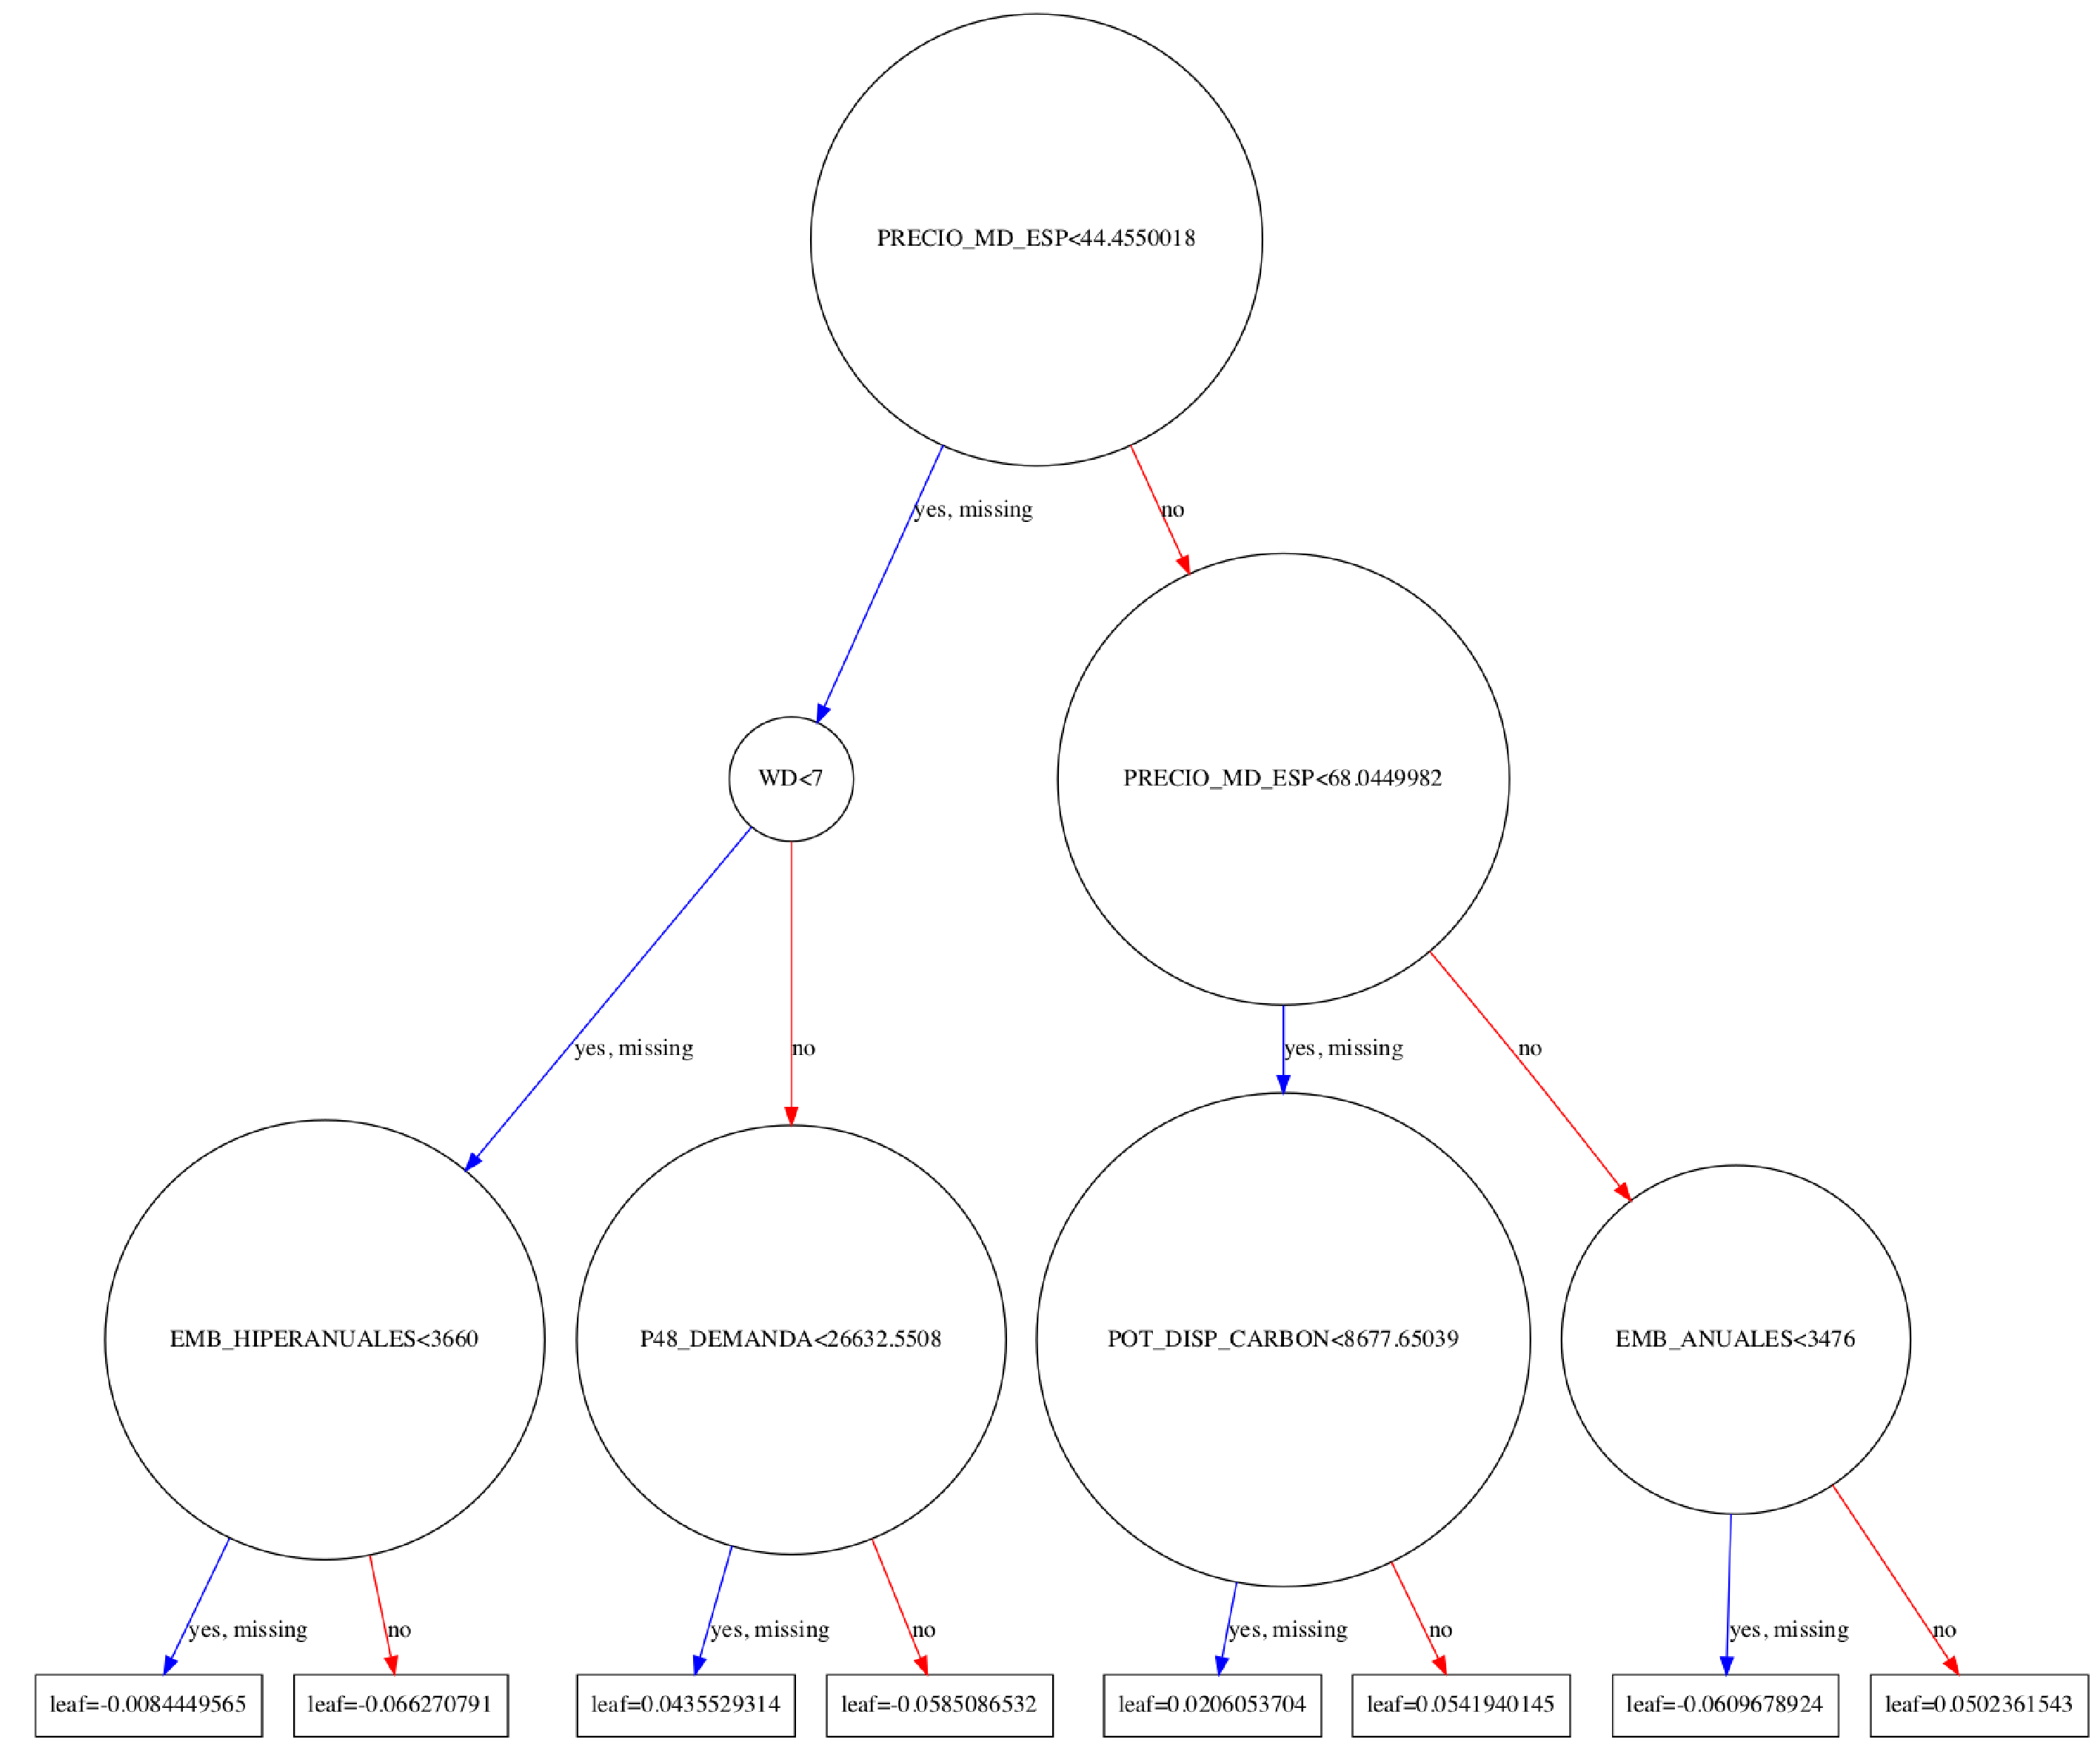

In [26]:
plot_tree(model,num_trees=3)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

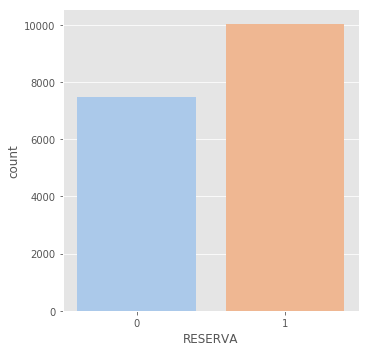

RESERVA = 1: 57.22%


In [51]:
g=sns.catplot('RESERVA',data=df_new,kind='count',palette='pastel')
plt.show()
print("RESERVA = 1: %.2f" %(df_new['RESERVA'].value_counts(normalize=True)[1]*100) + "%")

El accuracy del modelo no es muy elevado (70,15%).

El target RESERVA vale 1 un 57% de las veces. Eso quiere decir que, si mi estrategia fuese apostar siempre a que el precio del intradiario baja, acertaría un 57% de las veces. 

Con el modelo seleccionado, acierto un 13% más.

Incluyo la probabilidad con la que ha selecionado esa salida, para intentar ver si mi porcentaje de acierto aumenta cuando solo hago caso al modelo cuando me predice con cierta probabilidad, sin perder muchas oportunidades.

In [52]:
prob=list(model.predict_proba(X_test))
pred=list(model.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [65]:
df_pred_prob=pd.DataFrame(prob,columns=['PROB_0','PROB_1'])
df_pred_prob.head()

,PROB_0,PROB_1
0,0.588170,0.411830
1,0.525154,0.474846
2,0.504295,0.495705
3,0.497604,0.502396
4,0.360216,0.639784


In [66]:
df_pred_prob['PRED']=pred
df_pred_prob['TRUE']=list(y_test)
df_pred_prob.head()

,PROB_0,PROB_1,PRED,TRUE
0,0.588170,0.411830,0,1
1,0.525154,0.474846,0,1
2,0.504295,0.495705,0,0
3,0.497604,0.502396,1,1
4,0.360216,0.639784,1,1


In [59]:
BAJA_INTRA=df_pred_prob[df_pred_prob['TRUE']==1].copy()
SUBE_INTRA=df_pred_prob[df_pred_prob['TRUE']==0].copy()

In [67]:
BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1'].describe()

count    1645.000000
mean        0.702404
std         0.109452
min         0.500345
25%         0.615492
50%         0.700513
75%         0.787501
max         0.980100
Name: PROB_1, dtype: float64

In [68]:
BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_0'].describe()

count    1645.000000
mean        0.297596
std         0.109452
min         0.019900
25%         0.212499
50%         0.299487
75%         0.384508
max         0.499655
Name: PROB_0, dtype: float64

In [69]:
SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1'].describe()

count    705.000000
mean       0.634077
std        0.091261
min        0.500081
25%        0.556696
50%        0.623030
75%        0.697530
max        0.899994
Name: PROB_1, dtype: float64

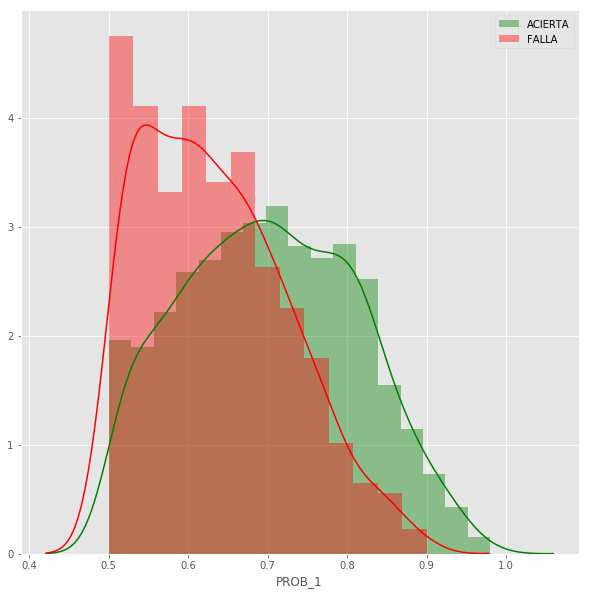

In [80]:
f, ax = plt.subplots(1, 1,figsize=[10,10])

sns.distplot(BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1'],ax=ax,color='green');
sns.distplot(SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1'],ax=ax,color='red');

ax.legend(labels=["ACIERTA","FALLA"]) 

plt.show()